# Libraries

In [1]:
import pandas as pd
import numpy as np
import sqlite3 
from pandasql import sqldf
from scipy import stats
import statsmodels.api as sm
from statsmodels.formula.api import ols
import random
import math
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

# Business Problem

Computing Vision (a made-up company for the purposes of this project) sees all the big companies creating original video content and they want to get in on the fun. They have decided to create a new movie studio, but they don’t have much background in creating movies. You are charged with exploring what types of films are currently doing the best at the box office using different samples of available data. You then will translate those findings into actionable insights that the head of Computing Vision's new movie studio can use to help decide what type of films to create.



# Data

Data files from:
- Box Office Mojo
- IMDB
- Rotten Tomatoes
- TheMovieDB
- The Numbers

In [2]:
bom_df = pd.read_csv('data/bom.movie_gross.csv.gz')
bom_df.head()

,title,studio,domestic_gross,foreign_gross,year
0,Toy Story 3,BV,415000000.0,652000000,2010
1,Alice in Wonderland (2010),BV,334200000.0,691300000,2010
2,Harry Potter and the Deathly Hallows Part 1,WB,296000000.0,664300000,2010
3,Inception,WB,292600000.0,535700000,2010
4,Shrek Forever After,P/DW,238700000.0,513900000,2010


In [3]:
tmdb_df = pd.read_csv('data/tmdb.movies.csv.gz', index_col = 0)
tmdb_df.head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
0,"[12, 14, 10751]",12444,en,Harry Potter and the Deathly Hallows: Part 1,33.533,2010-11-19,Harry Potter and the Deathly Hallows: Part 1,7.7,10788
1,"[14, 12, 16, 10751]",10191,en,How to Train Your Dragon,28.734,2010-03-26,How to Train Your Dragon,7.7,7610
2,"[12, 28, 878]",10138,en,Iron Man 2,28.515,2010-05-07,Iron Man 2,6.8,12368
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186


In [4]:
tn_df = pd.read_csv('data/tn.movie_budgets.csv.gz')
tn_df.head()

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,"Dec 18, 2009",Avatar,"$425,000,000","$760,507,625","$2,776,345,279"
1,2,"May 20, 2011",Pirates of the Caribbean: On Stranger Tides,"$410,600,000","$241,063,875","$1,045,663,875"
2,3,"Jun 7, 2019",Dark Phoenix,"$350,000,000","$42,762,350","$149,762,350"
3,4,"May 1, 2015",Avengers: Age of Ultron,"$330,600,000","$459,005,868","$1,403,013,963"
4,5,"Dec 15, 2017",Star Wars Ep. VIII: The Last Jedi,"$317,000,000","$620,181,382","$1,316,721,747"


In [5]:
# rt_r_df = pd.read_csv('data/rt.reviews.tsv', sep = '\t', encoding = 'latin1')
# rt_r_df.head()

In [6]:
# rt_info_df = pd.read_csv('data/rt.movie_info.tsv', sep = '\t', encoding = 'latin1')
# rt_info_df.head()

In [7]:
pysqldf = lambda q: sqldf(q, globals())
conn = sqlite3.connect("data/im.db")

imdb_df = pd.read_sql("""
SELECT mb.movie_id, primary_title, original_title, start_year, runtime_minutes, genres, averagerating, numvotes
FROM movie_basics as mb
LEFT JOIN movie_ratings as mr
ON mb.movie_id = mr.movie_id 
WHERE mb.start_year <= 2023 and mr.numvotes >= 14 and averagerating IS NOT NULL and mb.genres IS NOT NULL
""", conn)

imdb_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,"Action,Crime,Drama",7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,"Biography,Drama",7.2,43
2,tt0069049,The Other Side of the Wind,The Other Side of the Wind,2018,122.0,Drama,6.9,4517
3,tt0100275,The Wandering Soap Opera,La Telenovela Errante,2017,80.0,"Comedy,Drama,Fantasy",6.5,119
4,tt0112502,Bigfoot,Bigfoot,2017,NaN,"Horror,Thriller",4.1,32
...,...,...,...,...,...,...,...,...
55515,tt9904844,Ott Tänak: The Movie,Ott Tänak: The Movie,2019,125.0,Documentary,8.7,218
55516,tt9905412,Ottam,Ottam,2019,120.0,Drama,8.1,505
55517,tt9905462,Pengalila,Pengalila,2019,111.0,Drama,8.4,600
55518,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,Drama,8.4,365


# Data Understanding

In [8]:
# Function to calculate proportion of nulls to entire DataFrame

def proportion_na(df):
    return df.isna().sum()/len(df) * 100

In [9]:
# Change to datetime format to compare years in record

tmdb_df['release_date'] = pd.to_datetime(tmdb_df['release_date'])
tn_df['release_date'] = pd.to_datetime(tn_df['release_date'])

print('start year:', bom_df['year'].min(), 'end year:', bom_df['year'].max())
print('start year:', tmdb_df['release_date'].dt.year.min(), 'end year:', tmdb_df['release_date'].dt.year.max())
print('start year:', tn_df['release_date'].dt.year.min(), 'end year:', tn_df['release_date'].dt.year.max())

start year: 2010 end year: 2018
start year: 1930 end year: 2020
start year: 1915 end year: 2020


In [10]:
# Finding movie names that are in multiple DataFrames

bom_movies = list(bom_df['title'].unique())
tmdb_movies = list(tmdb_df['title'].unique())
tn_movies = list(tn_df['movie'].unique())
imdb_movies = list(imdb_df['primary_title'].unique())
#len([x for x in bom_movies if x in tmdb_movies])

print(len([x for x in tn_movies if x in tmdb_movies]))
print(len([x for x in tn_movies if x in bom_movies]))
print(len([x for x in tn_movies if x in imdb_movies]))
print(len([x for x in imdb_movies if x in bom_movies]))

1924
1238
2074
2596


# IMDB

In [11]:
imdb_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,start_year,runtime_minutes,averagerating,numvotes
count,55520.00000,51525.00000,55520.00000,55520.00000
mean,2014.29209,97.55179,6.16890,4684.40250
std,2.60509,235.95438,1.43526,34862.50738
min,2010.00000,5.00000,1.00000,14.00000
25%,2012.00000,84.00000,5.30000,34.00000
50%,2014.00000,93.00000,6.30000,109.00000
75%,2017.00000,105.00000,7.20000,500.00000
max,2019.00000,51420.00000,10.00000,1841066.00000


In [211]:
imdb_df[imdb_df['runtime_minutes'] < 500]['runtime_minutes']

0        175.0
1        114.0
2        122.0
3         80.0
5         83.0
         ...  
55515    125.0
55516    120.0
55517    111.0
55518    130.0
55519     98.0
Name: runtime_minutes, Length: 51516, dtype: float64

In [12]:
# # Filter out genres after war

# genre_lst = list(genres_count[genres_count > 800].index)

# dummy_df = imdb_df['genres'].str.get_dummies(',')[genre_lst]
# imdb_genres_df = pd.concat([imdb_df, dummy_df], axis = 1)

In [13]:
imdb_df['genres'] = imdb_df['genres'].str.split(',')

In [14]:
imdb_genres_df = imdb_df.explode('genres')
imdb_genres_df

,movie_id,primary_title,original_title,start_year,runtime_minutes,genres,averagerating,numvotes
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Action,7.0,77
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Crime,7.0,77
0,tt0063540,Sunghursh,Sunghursh,2013,175.0,Drama,7.0,77
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Biography,7.2,43
1,tt0066787,One Day Before the Rainy Season,Ashad Ka Ek Din,2019,114.0,Drama,7.2,43
...,...,...,...,...,...,...,...,...
55516,tt9905412,Ottam,Ottam,2019,120.0,Drama,8.1,505
55517,tt9905462,Pengalila,Pengalila,2019,111.0,Drama,8.4,600
55518,tt9911774,Padmavyuhathile Abhimanyu,Padmavyuhathile Abhimanyu,2019,130.0,Drama,8.4,365
55519,tt9914286,Sokagin Çocuklari,Sokagin Çocuklari,2019,98.0,Drama,8.7,136


In [15]:
imdb_genres_df.groupby('genres')[['averagerating', 'numvotes']].agg(['mean', 'median'])\
.sort_values(by = ('averagerating', 'mean'), ascending = False)[:10]

averagerating            numvotes       
                     mean median         mean median
genres                                              
Documentary      7.275600    7.3   435.425237   47.0
News             7.275211    7.3   342.107042   50.0
Biography        7.065687    7.1  7834.902430  121.0
Music            6.986226    7.1  3752.785813   94.5
History          6.918747    7.0  3896.922924  100.0
Sport            6.848799    7.0  4097.934498  141.5
War              6.471300    6.7  4010.889387  188.0
Reality-TV       6.400000    6.3    40.400000   29.5
Musical          6.389041    6.5  2712.616438   94.0
Drama            6.309374    6.4  4841.848161  134.0

# The Movie DB

In [16]:
# Check NA

proportion_na(tmdb_df)

genre_ids            0.0
id                   0.0
original_language    0.0
original_title       0.0
popularity           0.0
release_date         0.0
title                0.0
vote_average         0.0
vote_count           0.0
dtype: float64

In [17]:
# Check duplicates

tmdb_df[tmdb_df.duplicated()]

# Find IDs with more than 1 row
vc = tmdb_df['id'].value_counts()
more_than_1_id = list(vc[vc > 1].index)

tmdb_df[tmdb_df['id'].map(lambda x: True if x in more_than_1_id else False)].head()

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
10,"[16, 35, 10751]",863,en,Toy Story 2,22.698,1999-11-24,Toy Story 2,7.5,7553
43,"[35, 10749]",239,en,Some Like It Hot,14.200,1959-03-18,Some Like It Hot,8.2,1562
54,"[12, 28, 878]",20526,en,TRON: Legacy,13.459,2010-12-10,TRON: Legacy,6.3,4387
56,"[35, 16, 10751]",9994,en,The Great Mouse Detective,13.348,1986-07-02,The Great Mouse Detective,7.1,769


In [18]:
# Look into movies with duplicate IDs

tmdb_df[tmdb_df['id'] == 862]

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
3,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174
2473,"[16, 35, 10751]",862,en,Toy Story,28.005,1995-11-22,Toy Story,7.9,10174


In [19]:
tmdb_df[tmdb_df['id'] == 492837]

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
23804,[99],492837,en,Making Filmmakers,0.6,2018-04-07,Making Filmmakers,0.0,1
26511,[99],492837,en,Making Filmmakers,0.6,2018-04-07,Making Filmmakers,0.0,1


In [20]:
tmdb_df[tmdb_df['id'] == 292086]

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
5838,"[18, 53]",292086,en,Come Morning,3.013,2012-10-21,Come Morning,6.3,5
11836,"[18, 53]",292086,en,Come Morning,3.013,2012-10-21,Come Morning,6.3,5
21565,"[18, 53]",292086,en,Come Morning,3.013,2012-10-21,Come Morning,6.3,5


In [21]:
# Safe to drop duplicates

tmdb_df.drop_duplicates(subset = 'id', inplace = True)

### Summary Statistics

In [22]:
tmdb_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 25497 entries, 0 to 26516
Data columns (total 9 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   genre_ids          25497 non-null  object        
 1   id                 25497 non-null  int64         
 2   original_language  25497 non-null  object        
 3   original_title     25497 non-null  object        
 4   popularity         25497 non-null  float64       
 5   release_date       25497 non-null  datetime64[ns]
 6   title              25497 non-null  object        
 7   vote_average       25497 non-null  float64       
 8   vote_count         25497 non-null  int64         
dtypes: datetime64[ns](1), float64(2), int64(2), object(4)
memory usage: 1.9+ MB


In [23]:
tmdb_df.describe()

,id,popularity,vote_average,vote_count
count,25497.000000,25497.000000,25497.000000,25497.000000
mean,294203.960505,3.043279,5.979331,178.795780
std,154690.249660,4.261045,1.866094,914.150311
min,27.000000,0.600000,0.000000,1.000000
25%,154770.000000,0.600000,5.000000,1.000000
50%,307125.000000,1.321000,6.000000,5.000000
75%,420707.000000,3.490000,7.000000,25.000000
max,608444.000000,80.773000,10.000000,22186.000000


<AxesSubplot:ylabel='popularity'>

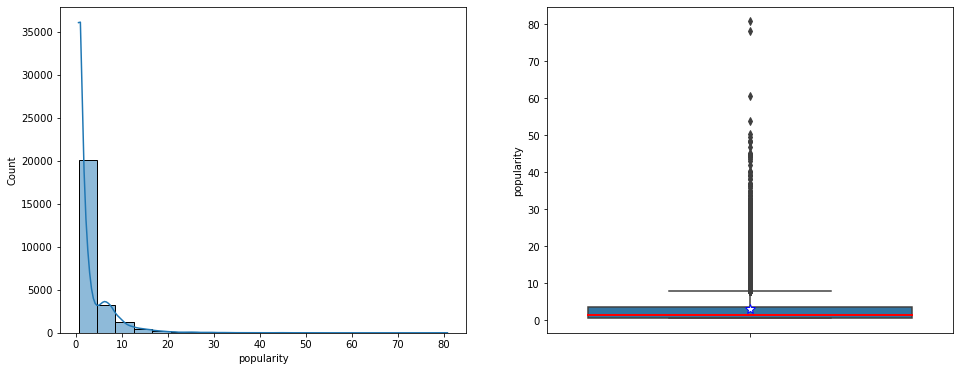

In [24]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.histplot(tmdb_df['popularity'], kde = True, bins = 20, ax = ax1)
sns.boxplot(y = tmdb_df['popularity'], showmeans = True, 
            meanprops={"marker":"*", "markerfacecolor":"white", "markeredgecolor":"blue", "markersize": "10"},
            medianprops={'color': 'red', 'linewidth': 2},  ax = ax2)

<AxesSubplot:ylabel='vote_average'>

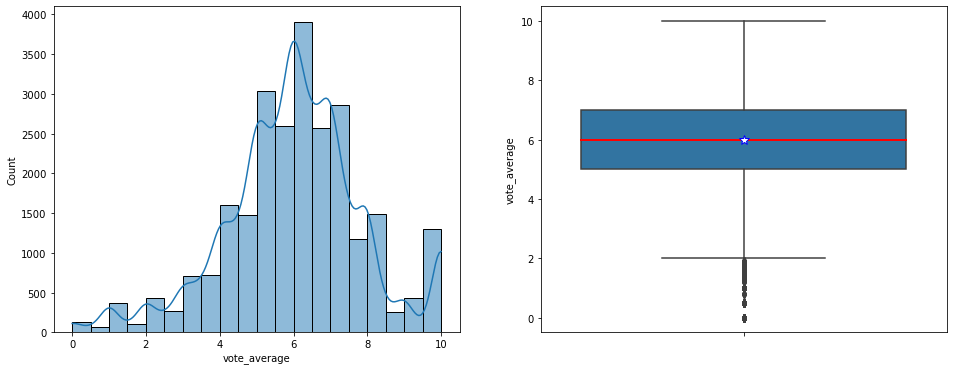

In [25]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.histplot(tmdb_df['vote_average'], kde = True, bins = 20, ax = ax1)
sns.boxplot(y = tmdb_df['vote_average'], showmeans = True, 
            meanprops={"marker":"*", "markerfacecolor":"white", "markeredgecolor":"blue", "markersize": "10"},
            medianprops={'color': 'red', 'linewidth': 2},  ax = ax2)

<AxesSubplot:ylabel='vote_count'>

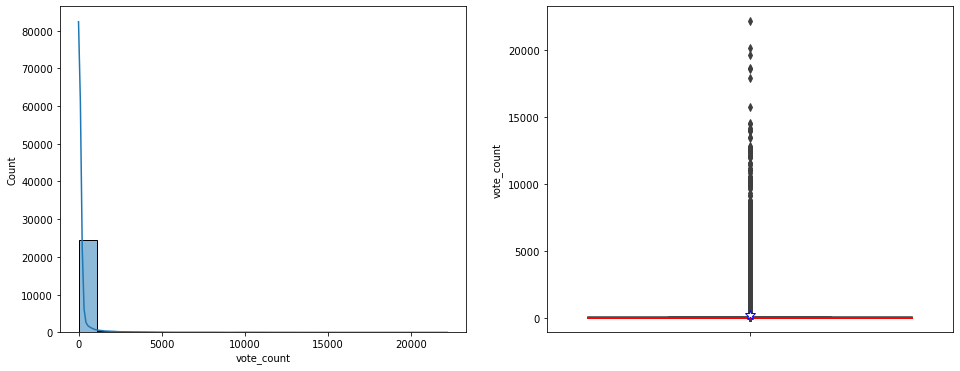

In [26]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.histplot(tmdb_df['vote_count'], kde = True, bins = 20, ax = ax1)
sns.boxplot(y = tmdb_df['vote_count'], showmeans = True, 
            meanprops={"marker":"*", "markerfacecolor":"white", "markeredgecolor":"blue", "markersize": "10"},
            medianprops={'color': 'red', 'linewidth': 2},  ax = ax2)

### Vote average follows a near-normal distribution, with mean and median around 6. Vote count & popularity have long tails with many outliers

- Popularity correlation with vote average & vote count?
- Feature engineer weighted score?
- Possible 80/20 distribution (genres vs. box office)?
- Best month to release movies?
- Time period sampling: budget vs. revenue behavior across different time periods 
- Budget confidence interval

In [27]:
tmdb_df.sort_values(by = 'popularity', ascending = False)[:10]

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
23811,"[12, 28, 14]",299536,en,Avengers: Infinity War,80.773,2018-04-27,Avengers: Infinity War,8.3,13948
11019,"[28, 53]",245891,en,John Wick,78.123,2014-10-24,John Wick,7.2,10081
23812,"[28, 12, 16, 878, 35]",324857,en,Spider-Man: Into the Spider-Verse,60.534,2018-12-14,Spider-Man: Into the Spider-Verse,8.4,4048
11020,"[28, 12, 14]",122917,en,The Hobbit: The Battle of the Five Armies,53.783,2014-12-17,The Hobbit: The Battle of the Five Armies,7.3,8392
5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673
11021,"[28, 878, 12]",118340,en,Guardians of the Galaxy,49.606,2014-08-01,Guardians of the Galaxy,7.9,17958
20617,"[878, 28, 53]",335984,en,Blade Runner 2049,48.571,2017-10-06,Blade Runner 2049,7.4,6679
23814,[12],338952,en,Fantastic Beasts: The Crimes of Grindelwald,48.508,2018-11-16,Fantastic Beasts: The Crimes of Grindelwald,6.9,4870
23815,"[10751, 16, 35, 14, 12]",404368,en,Ralph Breaks the Internet,48.057,2018-11-21,Ralph Breaks the Internet,7.2,2626
20618,"[28, 12, 878, 18]",315635,en,Spider-Man: Homecoming,46.775,2017-07-07,Spider-Man: Homecoming,7.4,11585


In [28]:
tmdb_df.sort_values(by = 'vote_average', ascending = False)[:10]

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
12835,"[99, 10770]",466033,en,OJ: Trial of the Century,0.878,2014-06-12,OJ: Trial of the Century,10.0,1
16532,"[18, 878, 53]",413367,en,Psychoacoustic,0.600,2015-10-23,Psychoacoustic,10.0,2
16521,[],442454,en,Afterimage,0.600,2015-09-13,Afterimage,10.0,1
16522,"[18, 9648]",441733,en,Healed,0.600,2015-10-15,Healed,10.0,1
16523,[99],434312,en,SelectED,0.600,2015-04-17,SelectED,10.0,2
16524,"[28, 80, 18, 53]",433390,en,No Charge,0.600,2015-05-31,No Charge,10.0,1
16525,[],428109,en,If I Could Talk,0.600,2015-04-15,If I Could Talk,10.0,1
16526,[],427932,en,I've Always Been Here,0.600,2015-01-25,I've Always Been Here,10.0,2
16527,"[10751, 16]",423119,en,Dear Sofia: A Royal Collection,0.600,2015-09-29,Dear Sofia: A Royal Collection,10.0,1
16528,[],419594,en,Black Water Wilderness,0.600,2015-01-12,Black Water Wilderness,10.0,1


In [29]:
tmdb_df.sort_values(by = 'vote_count', ascending = False)[:10]

,genre_ids,id,original_language,original_title,popularity,release_date,title,vote_average,vote_count
4,"[28, 878, 12]",27205,en,Inception,27.920,2010-07-16,Inception,8.3,22186
17383,"[28, 12, 35]",293660,en,Deadpool,35.067,2016-02-12,Deadpool,7.6,20175
5179,"[878, 28, 12]",24428,en,The Avengers,50.289,2012-05-04,The Avengers,7.6,19673
6,"[28, 12, 14, 878]",19995,en,Avatar,26.526,2009-12-18,Avatar,7.4,18676
11032,"[12, 18, 878]",157336,en,Interstellar,28.440,2014-11-05,Interstellar,8.2,18597
11021,"[28, 878, 12]",118340,en,Guardians of the Galaxy,49.606,2014-08-01,Guardians of the Galaxy,7.9,17958
5189,"[18, 37]",68718,en,Django Unchained,21.260,2012-12-25,Django Unchained,8.0,15725
5235,"[878, 12, 14]",70160,en,The Hunger Games,14.212,2012-03-23,The Hunger Games,7.1,14587
14177,"[28, 12, 878]",76341,en,Mad Max: Fury Road,28.099,2015-05-15,Mad Max: Fury Road,7.4,14454
7881,"[28, 12, 878]",68721,en,Iron Man 3,32.093,2013-05-03,Iron Man 3,6.9,14155


- The most popular movies have a lot of vote counts; the movies with the highest average only has 1 vote (bias or outliers)

In [30]:
tmdb_corr = tmdb_df[['popularity', 'vote_average', 'vote_count']].corr()
tmdb_corr

,popularity,vote_average,vote_count
popularity,1.000000,0.057178,0.685285
vote_average,0.057178,1.000000,0.079160
vote_count,0.685285,0.079160,1.000000


### Map genre IDs into genre descriptions

In [31]:
genre_dict = {
'Action':          28,
'Adventure':       12,
'Animation':       16,
'Comedy':          35,
'Crime':           80,
'Documentary':     99,
'Drama':           18,
'Family':          10751,
'Fantasy':         14,
'History':         36,
'Horror':          27,
'Music':           10402,
'Mystery':         9648,
'Romance':         10749,
'Sci-Fi':          878,
'TV Movie':        10770,
'Thriller':        53,
'War':             10752,
'Western':         37,
}

genre_dict = dict((v,k) for k,v in genre_dict.items())

In [32]:
def map_genre(ids):
    
    genre_lst = []

    if len(ids) > 2:
        id_lst = ids.strip('[]').split(',')        
        
        for i in id_lst:
            genre_lst.append(genre_dict[int(i)])

    else:
        genre_lst.append('Unknown')
        
    return ', '.join(genre_lst)

In [33]:
tmdb_df['genre'] = tmdb_df['genre_ids'].map(map_genre)

In [34]:
tmdb_df.groupby('genre')[['popularity', 'vote_average', 'vote_count']].median()

,popularity,vote_average,vote_count
genre,,,
Action,1.744,5.30,5.5
"Action, Adventure",1.648,5.60,8.5
"Action, Adventure, Animation",9.183,6.90,277.0
"Action, Adventure, Animation, Comedy, Family",9.086,5.60,47.0
"Action, Adventure, Animation, Comedy, Family, Fantasy",16.290,6.80,3873.0
...,...,...,...
"Western, Music, Mystery, Drama",1.393,10.00,1.0
"Western, Mystery, Drama, Music",0.600,10.00,1.0
"Western, Mystery, Music, Drama",0.600,10.00,1.0


# The Numbers

In [35]:
# Check NA
proportion_na(tn_df)

id                   0.0
release_date         0.0
movie                0.0
production_budget    0.0
domestic_gross       0.0
worldwide_gross      0.0
dtype: float64

In [36]:
# Check duplicates

tn_df[tn_df.duplicated()]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross


In [37]:
tn_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5782 entries, 0 to 5781
Data columns (total 6 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   id                 5782 non-null   int64         
 1   release_date       5782 non-null   datetime64[ns]
 2   movie              5782 non-null   object        
 3   production_budget  5782 non-null   object        
 4   domestic_gross     5782 non-null   object        
 5   worldwide_gross    5782 non-null   object        
dtypes: datetime64[ns](1), int64(1), object(4)
memory usage: 271.2+ KB


In [38]:
# Clean the production budget, domestic gross and worldwide gross columns
# Remove $ and ,

tn_df['production_budget'] = tn_df['production_budget'].map(lambda x: int(x.strip('$').replace(',', '')))
tn_df['domestic_gross'] = tn_df['domestic_gross'].map(lambda x: int(x.strip('$').replace(',', '')))
tn_df['worldwide_gross'] = tn_df['worldwide_gross'].map(lambda x: int(x.strip('$').replace(',', '')))

In [39]:
tn_df.describe().apply(lambda s: s.apply('{0:.5f}'.format))

,id,production_budget,domestic_gross,worldwide_gross
count,5782.00000,5782.00000,5782.00000,5782.00000
mean,50.37236,31587757.09651,41873326.86700,91487460.90643
std,28.82108,41812076.82694,68240597.35690,174719968.77890
min,1.00000,1100.00000,0.00000,0.00000
25%,25.00000,5000000.00000,1429534.50000,4125414.75000
50%,50.00000,17000000.00000,17225945.00000,27984448.50000
75%,75.00000,40000000.00000,52348661.50000,97645836.50000
max,100.00000,425000000.00000,936662225.00000,2776345279.00000


<AxesSubplot:ylabel='production_budget'>

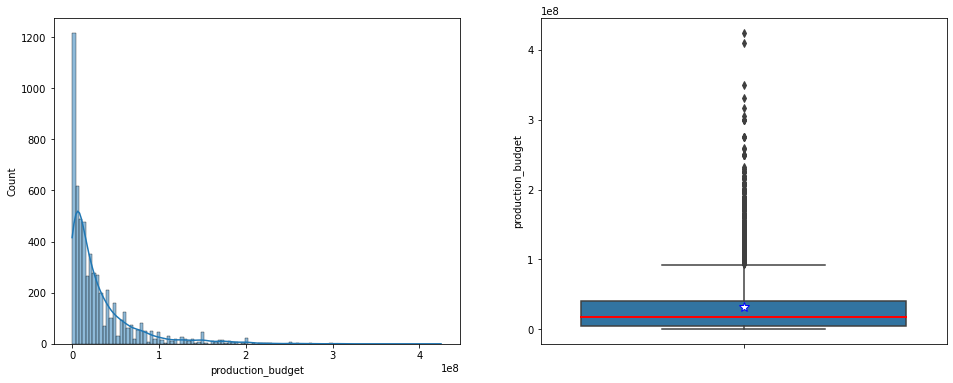

In [40]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.histplot(tn_df['production_budget'], kde = True, ax = ax1)
sns.boxplot(y = tn_df['production_budget'], showmeans = True, 
            meanprops={"marker":"*", "markerfacecolor":"white", "markeredgecolor":"blue", "markersize": "10"},
            medianprops={'color': 'red', 'linewidth': 2},  ax = ax2)

<AxesSubplot:ylabel='domestic_gross'>

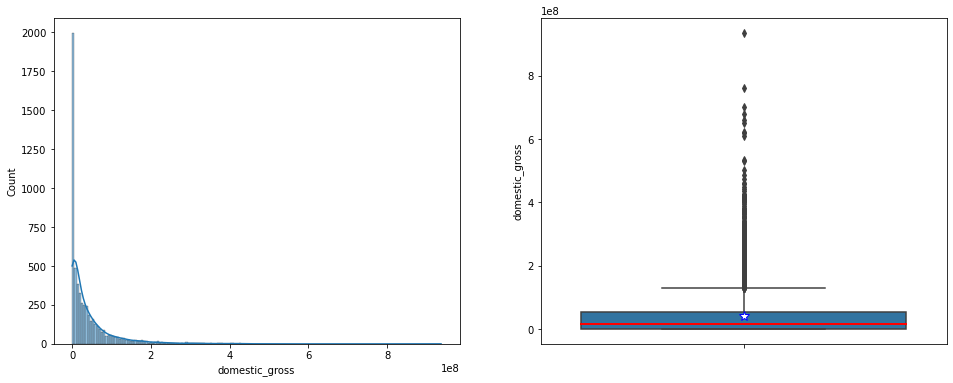

In [41]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.histplot(tn_df['domestic_gross'], kde = True, ax = ax1)
sns.boxplot(y = tn_df['domestic_gross'], showmeans = True, 
            meanprops={"marker":"*", "markerfacecolor":"white", "markeredgecolor":"blue", "markersize": "10"},
            medianprops={'color': 'red', 'linewidth': 2},  ax = ax2)

<AxesSubplot:ylabel='worldwide_gross'>

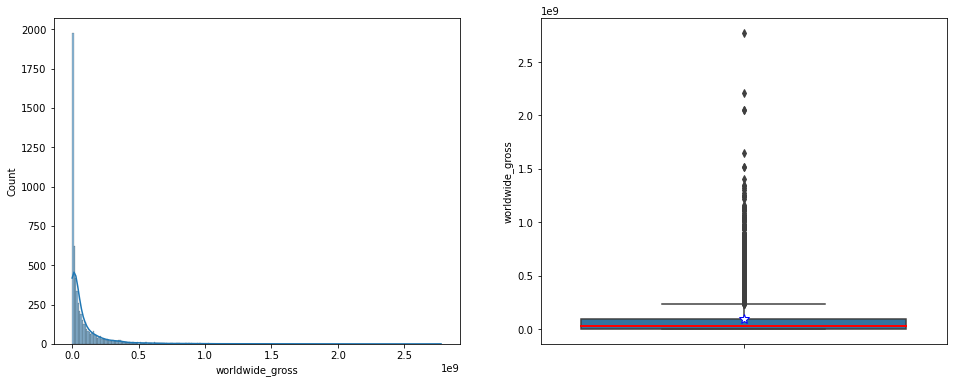

In [42]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (16, 6))

sns.histplot(tn_df['worldwide_gross'], kde = True, ax = ax1)
sns.boxplot(y = tn_df['worldwide_gross'], showmeans = True, 
            meanprops={"marker":"*", "markerfacecolor":"white", "markeredgecolor":"blue", "markersize": "10"},
            medianprops={'color': 'red', 'linewidth': 2},  ax = ax2)

In [43]:
tn_df.sort_values(by = 'worldwide_gross', ascending = False)[:10]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross
0,1,2009-12-18,Avatar,425000000,760507625,2776345279
42,43,1997-12-19,Titanic,200000000,659363944,2208208395
5,6,2015-12-18,Star Wars Ep. VII: The Force Awakens,306000000,936662225,2053311220
6,7,2018-04-27,Avengers: Infinity War,300000000,678815482,2048134200
33,34,2015-06-12,Jurassic World,215000000,652270625,1648854864
66,67,2015-04-03,Furious 7,190000000,353007020,1518722794
26,27,2012-05-04,The Avengers,225000000,623279547,1517935897
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963
41,42,2018-02-16,Black Panther,200000000,700059566,1348258224
260,61,2011-07-15,Harry Potter and the Deathly Hallows: Part II,125000000,381193157,1341693157


In [44]:
tn_df['year'] = tn_df['release_date'].dt.year
tn_df = tn_df[tn_df['year'] > 2000]

tn_df['month'] = tn_df['release_date'].dt.month
tn_df['day'] = tn_df['release_date'].dt.weekday

In [45]:
tn_df['profitability'] = tn_df['worldwide_gross']/tn_df['production_budget']
tn_df.sort_values(by = 'profitability', ascending = False)[:10]

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,day,profitability
5492,93,2009-09-25,Paranormal Activity,450000,107918810,194183034,2009,9,4,431.517853
5679,80,2015-07-10,The Gallows,100000,22764410,41656474,2015,7,4,416.564740
5709,10,2004-05-07,Super Size Me,65000,11529368,22233808,2004,5,4,342.058585
5781,82,2005-08-05,My Date With Drew,1100,181041,181041,2005,8,4,164.582727
5656,57,2007-05-16,Once,150000,9445857,23323631,2007,5,2,155.490873
5774,75,2004-10-08,Primer,7000,424760,841926,2004,10,4,120.275143
5507,8,2004-06-11,Napoleon Dynamite,400000,44540956,46122713,2004,6,4,115.306782
5430,31,2004-08-06,Open Water,500000,30500882,55518641,2004,8,4,111.037282
5680,81,2006-09-29,Facing the Giants,100000,10178331,10243159,2006,9,4,102.431590
5211,12,2012-01-06,The Devil Inside,1000000,53262945,101759490,2012,1,4,101.759490


In [46]:
tn_df

,id,release_date,movie,production_budget,domestic_gross,worldwide_gross,year,month,day,profitability
0,1,2009-12-18,Avatar,425000000,760507625,2776345279,2009,12,4,6.532577
1,2,2011-05-20,Pirates of the Caribbean: On Stranger Tides,410600000,241063875,1045663875,2011,5,4,2.546673
2,3,2019-06-07,Dark Phoenix,350000000,42762350,149762350,2019,6,4,0.427892
3,4,2015-05-01,Avengers: Age of Ultron,330600000,459005868,1403013963,2015,5,4,4.243841
4,5,2017-12-15,Star Wars Ep. VIII: The Last Jedi,317000000,620181382,1316721747,2017,12,4,4.153696
...,...,...,...,...,...,...,...,...,...,...
5776,77,2004-12-31,The Mongol King,7000,900,900,2004,12,4,0.128571
5777,78,2018-12-31,Red 11,7000,0,0,2018,12,0,0.000000
5779,80,2005-07-13,Return to the Land of Wonders,5000,1338,1338,2005,7,2,0.267600
5780,81,2015-09-29,A Plague So Pleasant,1400,0,0,2015,9,1,0.000000


### Worldwide gross & profitability by month

In [219]:
title_font = {'fontname':'Calibri', 'size':'18', 'color':'black', 'weight':'normal',
              'verticalalignment':'bottom'} 

label_font = {'fontname':'Calibri', 'size':'16', 'weight':'normal'}

months_x_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']


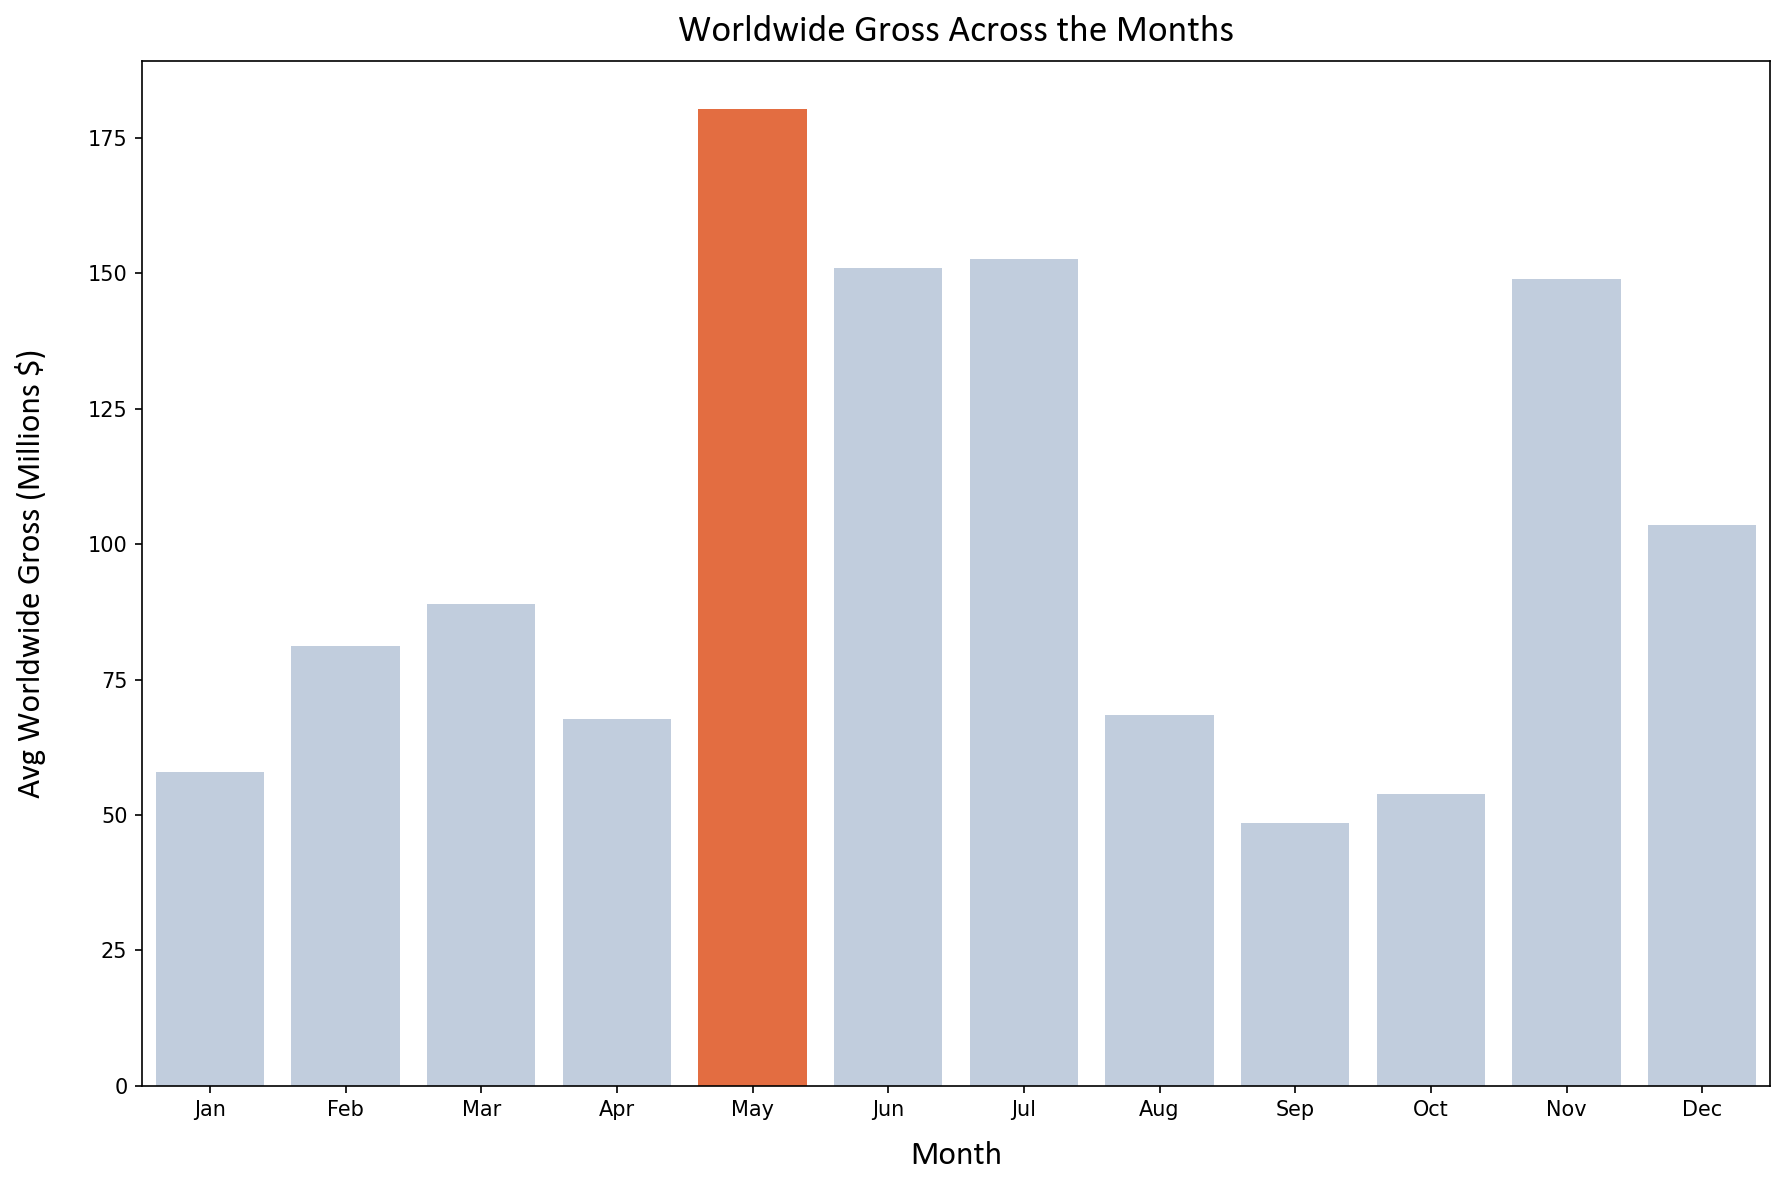

In [224]:
wg_month = (tn_df.groupby(['month'])[['worldwide_gross']].mean()/1000000).reset_index()

fig, ax = plt.subplots(figsize = (12, 8), dpi = 150)

cols = ['lightsteelblue' if x < wg_month['worldwide_gross'].max() else 'orangered' for x in wg_month['worldwide_gross']]
sns.barplot(x = wg_month['month'], y = wg_month['worldwide_gross'], palette = cols, alpha = 0.85, ax = ax)
ax.set_title('Worldwide Gross Across the Months', title_font)
ax.set_xlabel('Month', label_font, labelpad = 10)
ax.set_ylabel('Avg Worldwide Gross (Millions $)', label_font, labelpad = 20)
ax.set_xticklabels(months_x_ticks)
plt.tight_layout()

In [242]:
sort = profit_month['profitability'].sort_values(ascending = False)
sort.iloc[0]

4.837625218732888

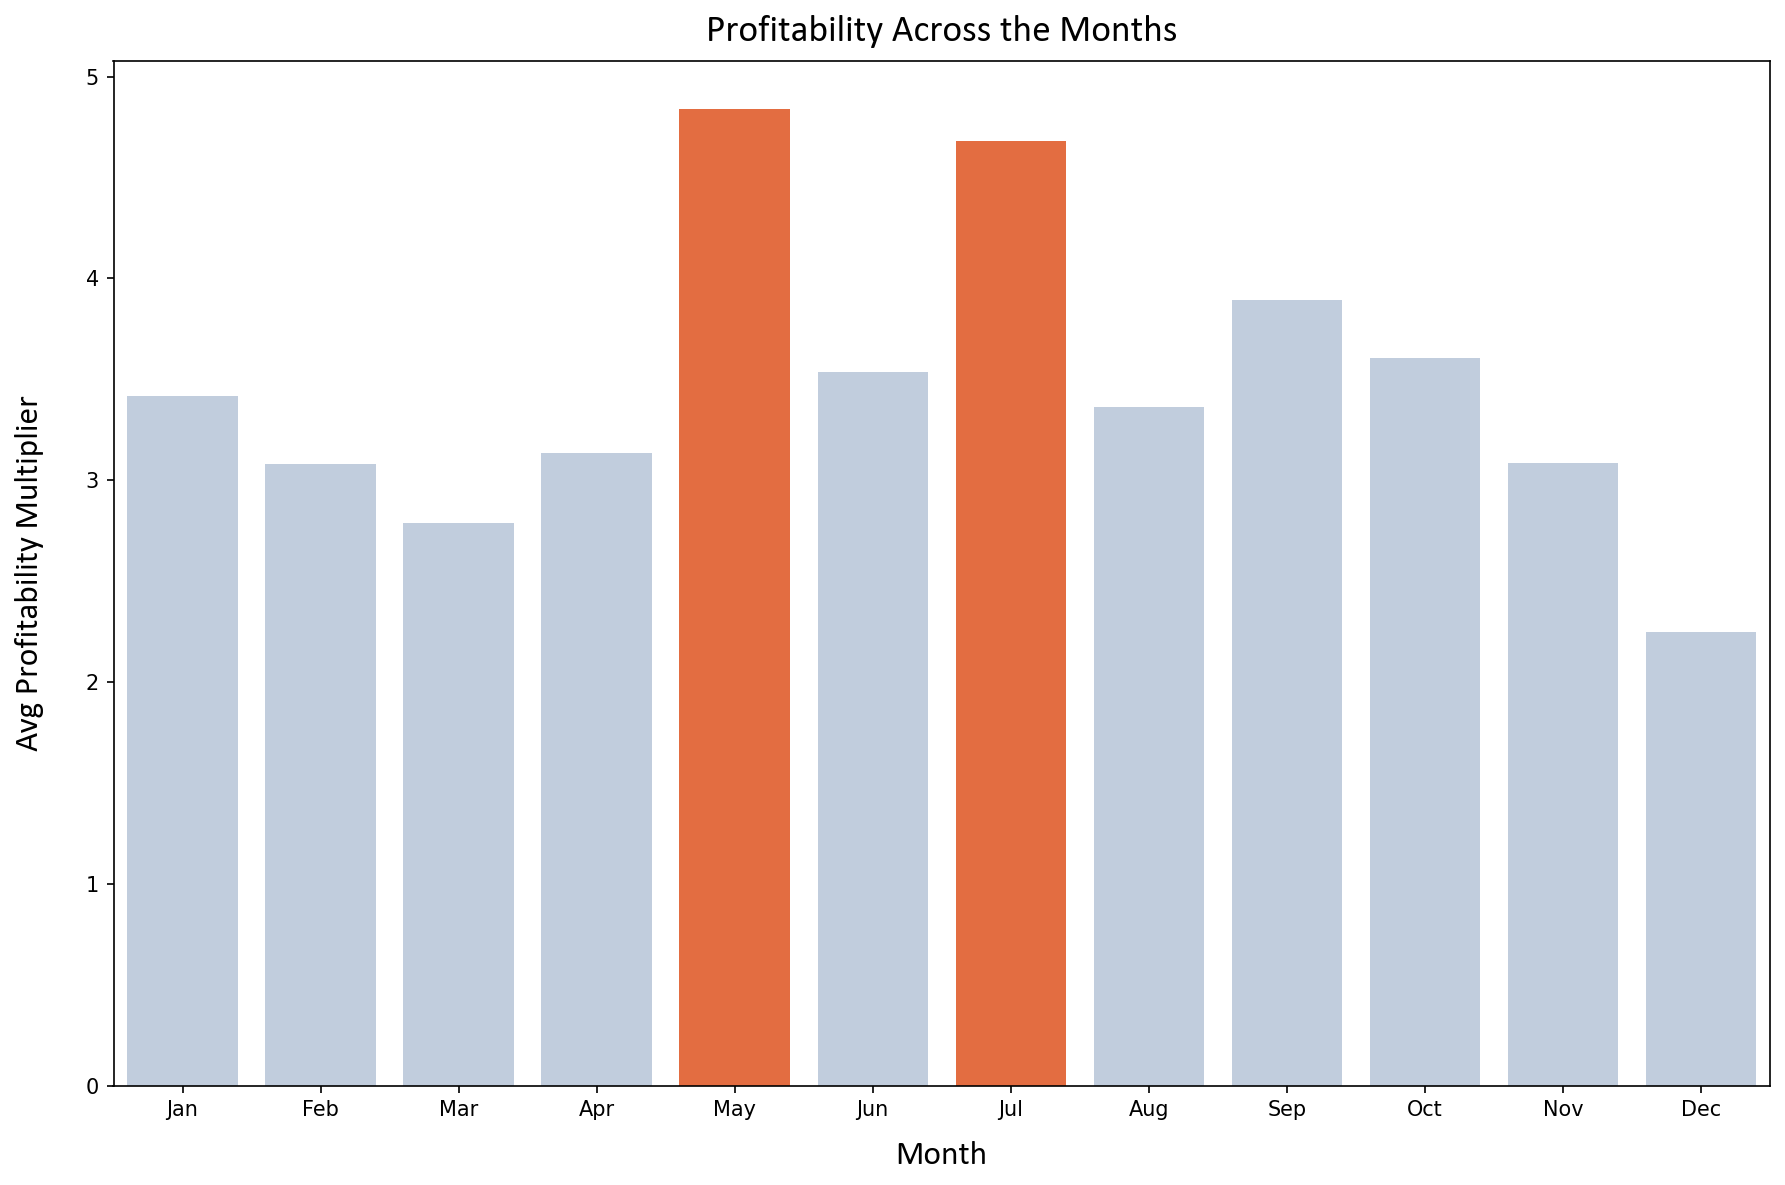

In [244]:
profit_month = (tn_df.groupby(['month'])[['profitability']].mean()).reset_index()

fig, ax = plt.subplots(figsize = (12, 8), dpi = 150)

cols = ['lightsteelblue' if x < profit_month['profitability'].sort_values(ascending = False).iloc[1] else 'orangered' for x in profit_month['profitability']]
sns.barplot(x = profit_month['month'], y = profit_month['profitability'], palette = cols, alpha = 0.85, ax = ax)
ax.set_title('Profitability Across the Months', title_font)
ax.set_xlabel('Month', label_font, labelpad = 10)
ax.set_ylabel('Avg Profitability Multiplier', label_font, labelpad = 20)
ax.set_xticklabels(months_x_ticks)
plt.tight_layout()

# Budget vs. Worldwide Gross

In [50]:
tn_df[['production_budget', 'domestic_gross', 'worldwide_gross']].corr()

,production_budget,domestic_gross,worldwide_gross
production_budget,1.000000,0.731389,0.780407
domestic_gross,0.731389,1.000000,0.942976
worldwide_gross,0.780407,0.942976,1.000000


In [51]:
top_quantile = tn_df[tn_df['worldwide_gross'] > tn_df['worldwide_gross'].quantile(0.75)]

<AxesSubplot:xlabel='production_budget', ylabel='worldwide_gross'>

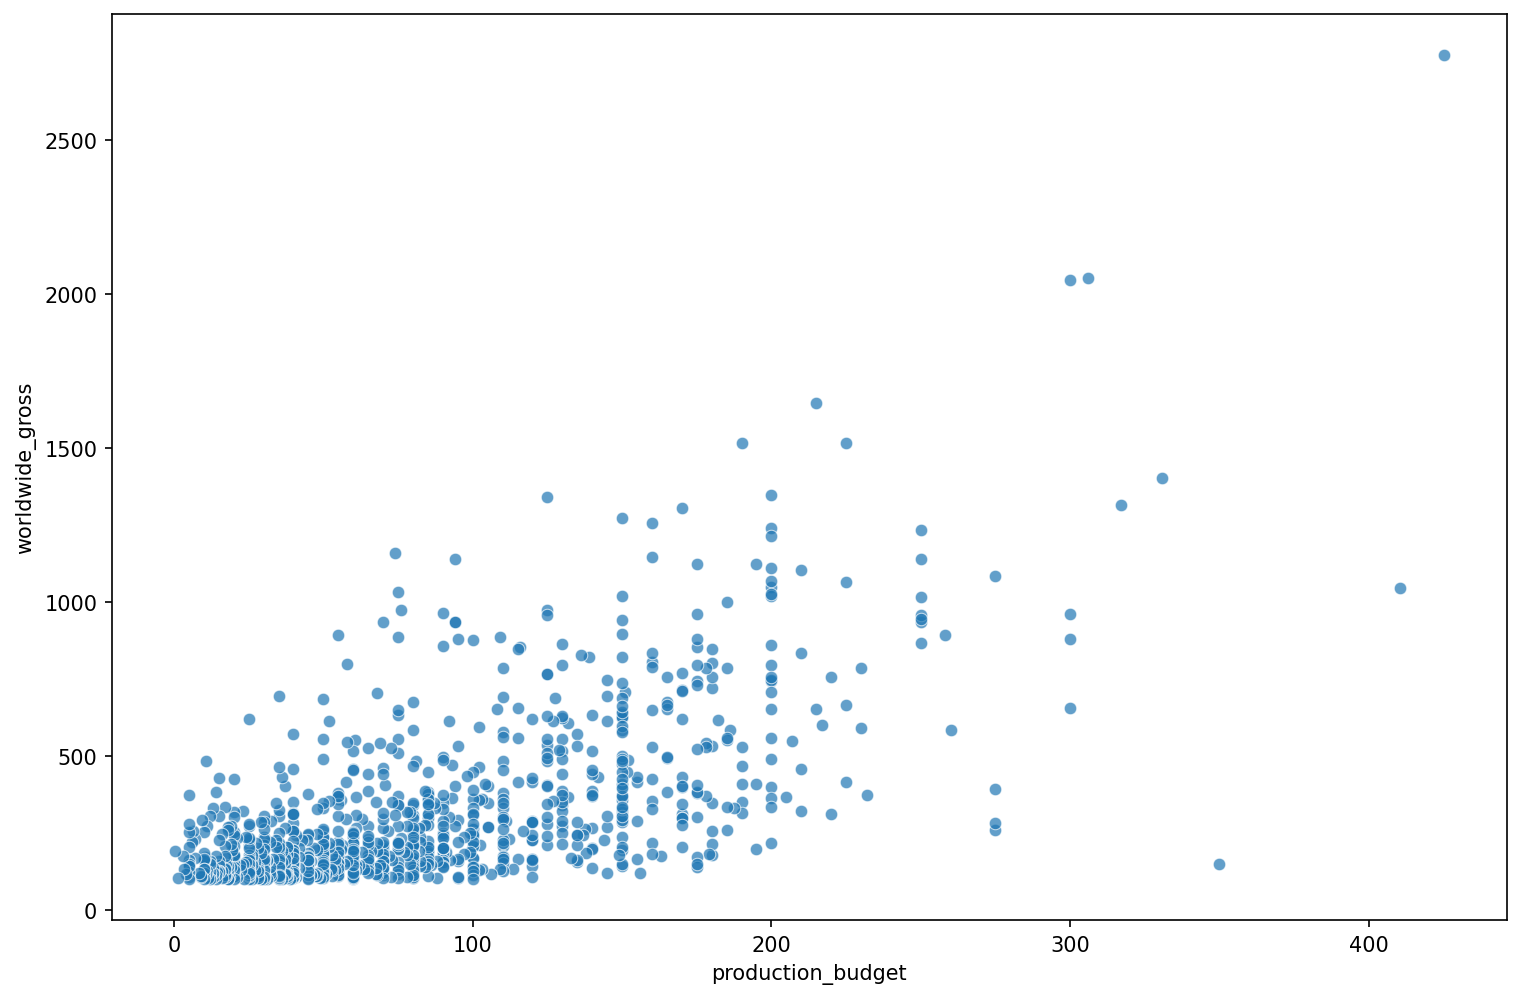

In [52]:
fig, ax = plt.subplots(figsize = (12, 8), dpi = 150)

sns.scatterplot(top_quantile['production_budget']/1000000, top_quantile['worldwide_gross']/1000000, alpha = 0.7)

### Worldwide gross & profitability by day of week

<AxesSubplot:xlabel='day'>

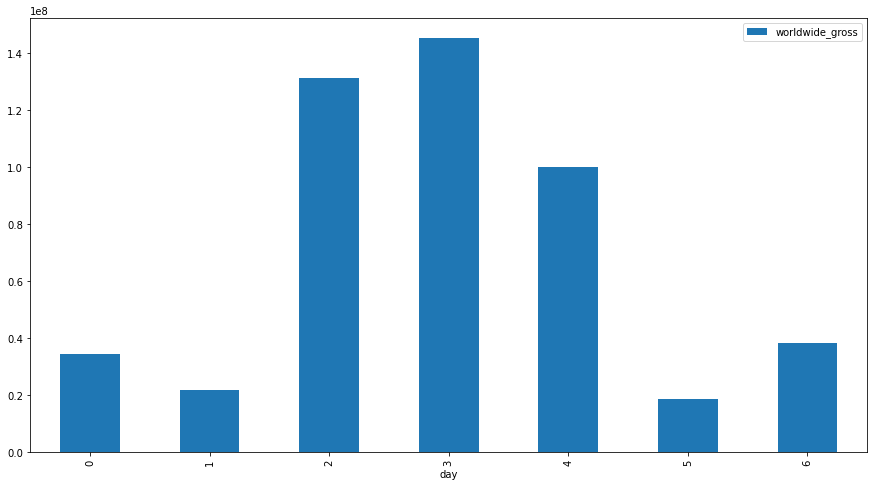

In [53]:
tn_df.groupby(['day'])[['worldwide_gross']].mean().plot(kind = 'bar', figsize = (15, 8))

<AxesSubplot:xlabel='day'>

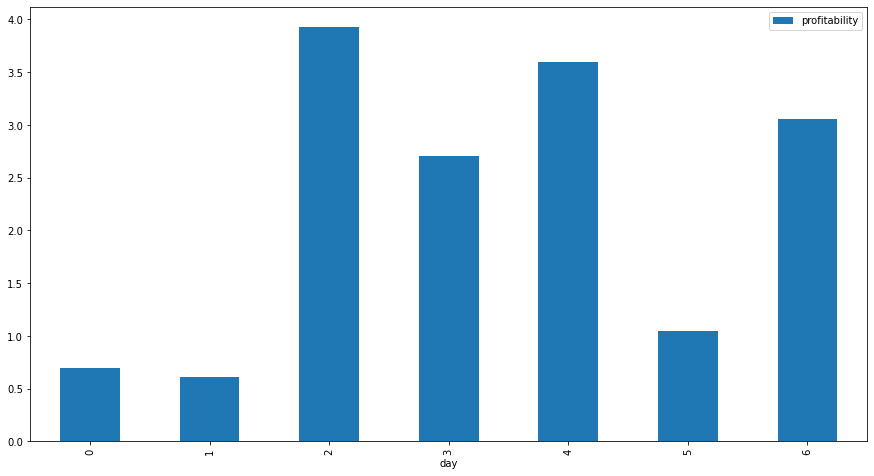

In [54]:
tn_df.groupby(['day'])[['profitability']].mean().plot(kind = 'bar', figsize = (15, 8))

### Popularity by month & day of week

In [55]:
tmdb_df['year'] = tmdb_df['release_date'].dt.year
tmdb_df = tmdb_df[tmdb_df['year'].astype(int) > 2000]

tmdb_df['month'] = tmdb_df['release_date'].dt.month
tmdb_df['day'] = tmdb_df['release_date'].dt.weekday


<AxesSubplot:xlabel='month'>

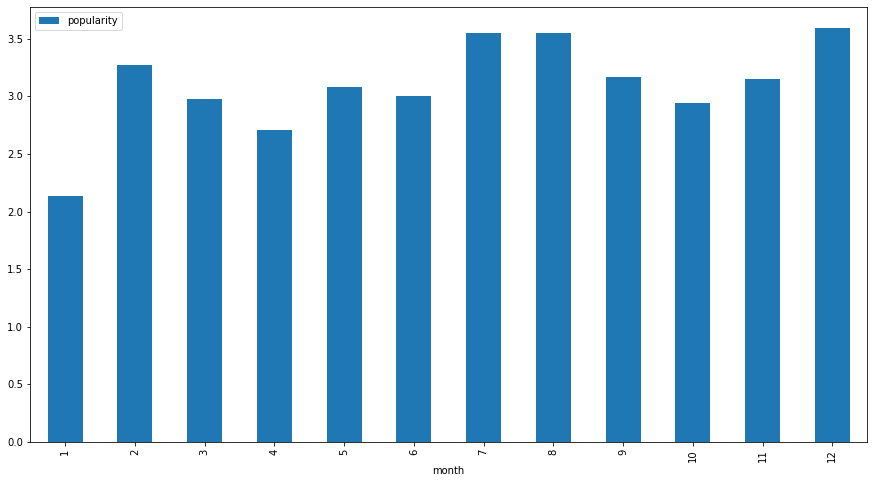

In [141]:
tmdb_df.groupby(['month'])[['popularity']].mean().plot(kind = 'bar', figsize = (15, 8))

<AxesSubplot:xlabel='day'>

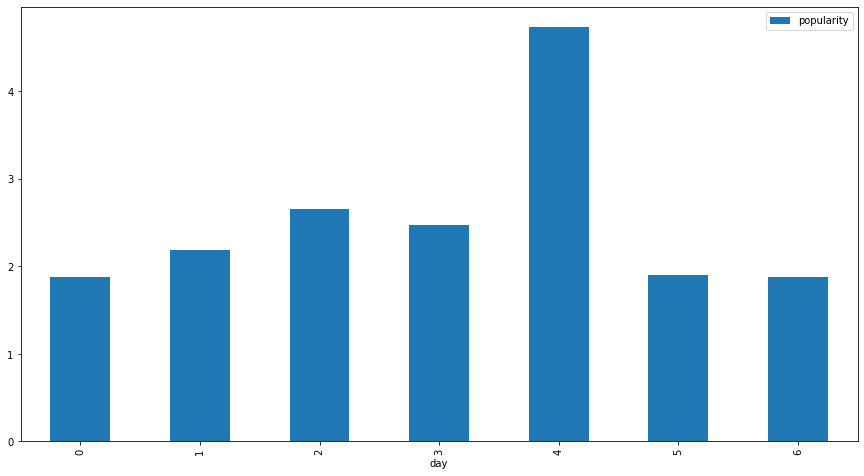

In [57]:
tmdb_df.groupby(['day'])[['popularity']].mean().plot(kind = 'bar', figsize = (15, 8))

In [103]:
merge_df = pd.merge(imdb_df, tn_df, how = 'inner', left_on = 'primary_title', right_on = 'movie')
merged_df = merge_df[merge_df['worldwide_gross'] != 0]

In [104]:
merged_df = merged_df.explode('genres')

In [130]:
top_genres = ['Documentary', 'Biography', 'Music', 'History']

genres_profit = merged_df.groupby(['genres', 'month'])[['profitability']].mean().reset_index()
top_profit = genres_profit[genres_profit['genres'].map(lambda x: x in top_genres)]

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

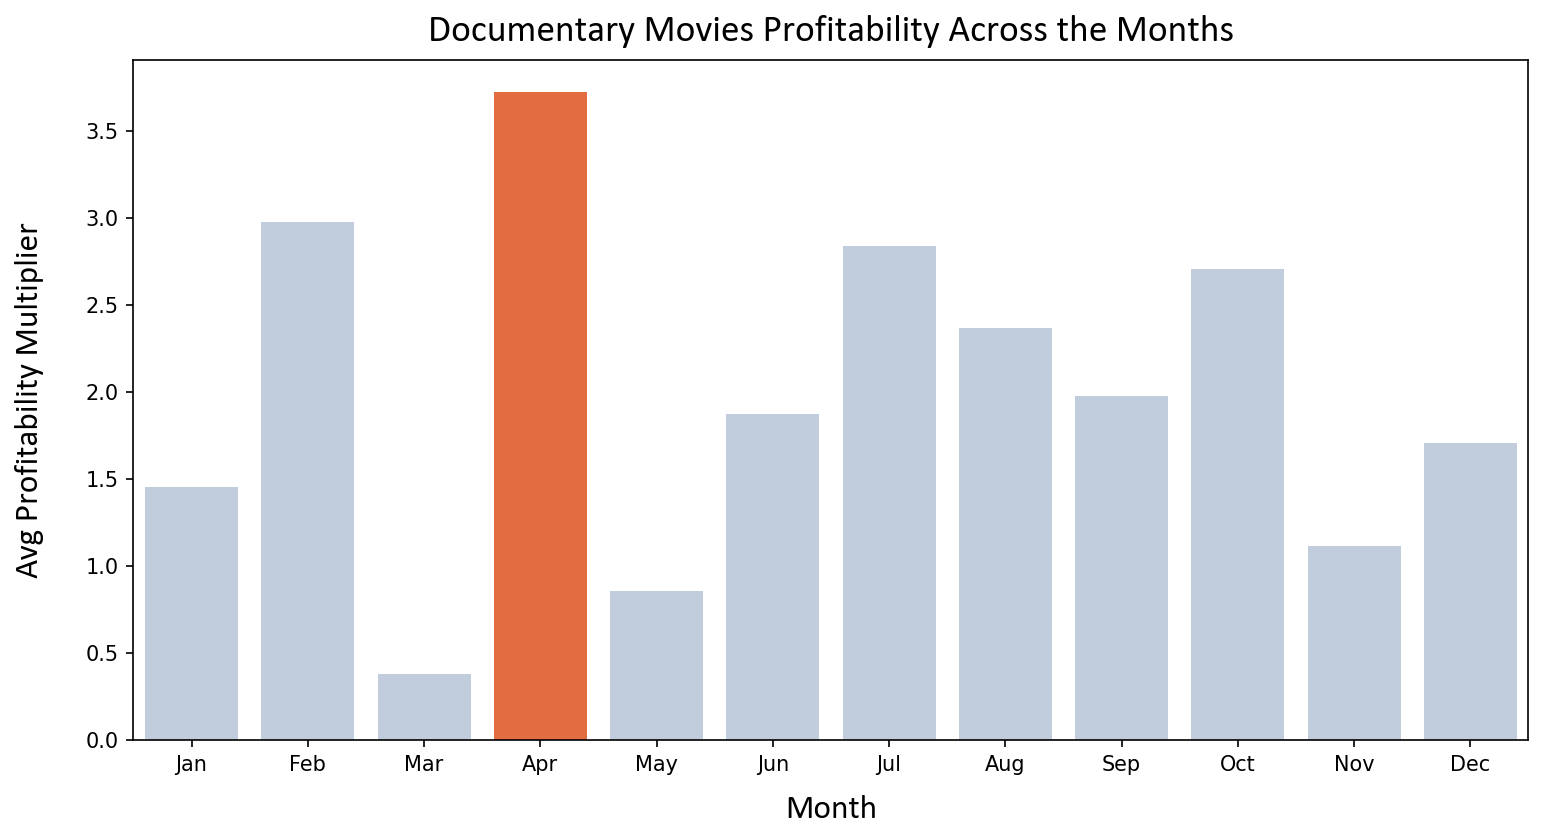

In [148]:
top_profit_d = top_profit[top_profit['genres'] == 'Documentary']

fig, ax = plt.subplots(figsize = (12, 6), dpi = 150)
cols = ['lightsteelblue' if x < top_profit_d['profitability'].max() else 'orangered' for x in top_profit_d['profitability']]
sns.barplot(x = top_profit_d['month'], y = top_profit_d['profitability'], palette = cols, alpha = 0.85, ax = ax)
ax.set_title('Documentary Movies Profitability Across the Months', title_font)
ax.set_xlabel('Month', label_font, labelpad = 10)
ax.set_ylabel('Avg Profitability Multiplier', label_font, labelpad = 20)
ax.set_xticklabels(months_x_ticks)

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

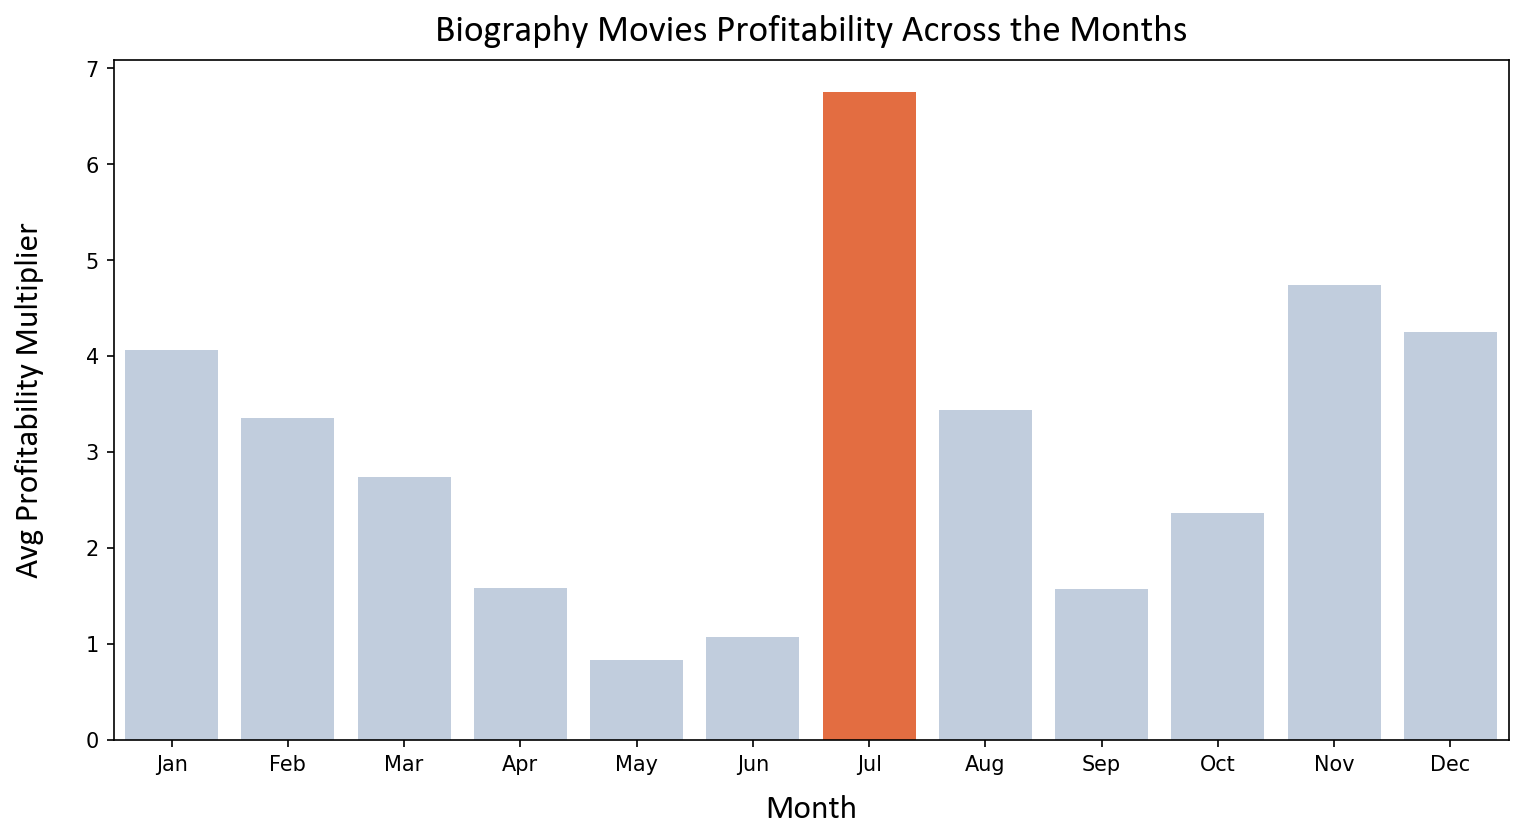

In [149]:
top_profit_b = top_profit[top_profit['genres'] == 'Biography']

fig, ax = plt.subplots(figsize = (12, 6), dpi = 150)
cols = ['lightsteelblue' if x < top_profit_b['profitability'].max() else 'orangered' for x in top_profit_b['profitability']]
sns.barplot(x = top_profit_b['month'], y = top_profit_b['profitability'], palette = cols, alpha = 0.85, ax = ax)
ax.set_title('Biography Movies Profitability Across the Months', title_font)
ax.set_xlabel('Month', label_font, labelpad = 10)
ax.set_ylabel('Avg Profitability Multiplier', label_font, labelpad = 20)
ax.set_xticklabels(months_x_ticks)

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

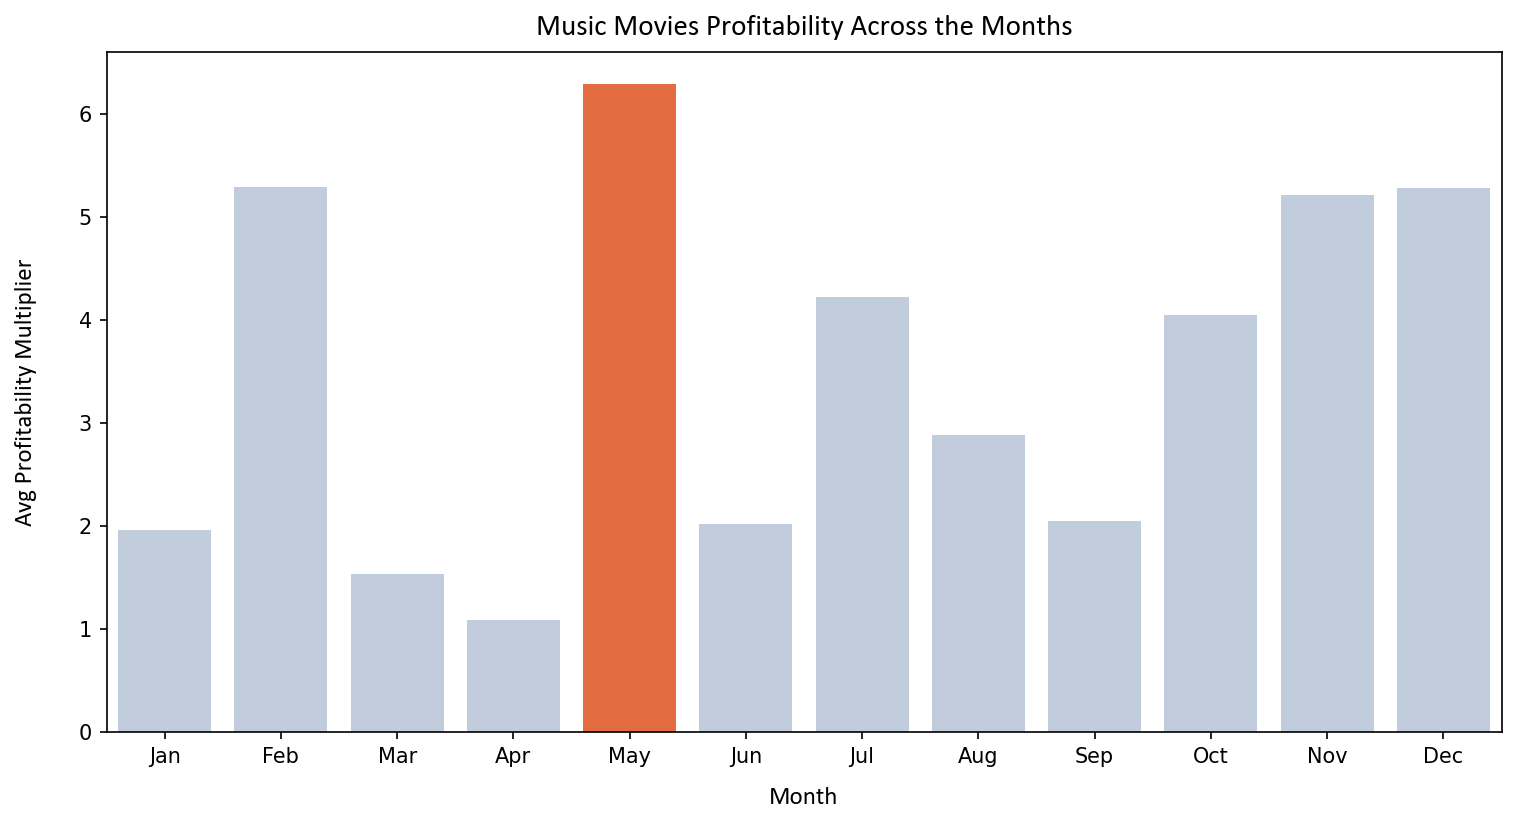

In [191]:
top_profit_m = top_profit[top_profit['genres'] == 'Music']

fig, ax = plt.subplots(figsize = (12, 6), dpi = 150)
cols = ['lightsteelblue' if x < top_profit_m['profitability'].max() else 'orangered' for x in top_profit_m['profitability']]
sns.barplot(x = top_profit_m['month'], y = top_profit_m['profitability'], palette = cols, alpha = 0.85, ax = ax)
ax.set_title('Music Movies Profitability Across the Months', title_font)
ax.set_xlabel('Month', label_font, labelpad = 10)
ax.set_ylabel('Avg Profitability Multiplier', label_font, labelpad = 20)
ax.set_xticklabels(months_x_ticks)

[Text(0, 0, 'Jan'),
 Text(1, 0, 'Feb'),
 Text(2, 0, 'Mar'),
 Text(3, 0, 'Apr'),
 Text(4, 0, 'May'),
 Text(5, 0, 'Jun'),
 Text(6, 0, 'Jul'),
 Text(7, 0, 'Aug'),
 Text(8, 0, 'Sep'),
 Text(9, 0, 'Oct'),
 Text(10, 0, 'Nov'),
 Text(11, 0, 'Dec')]

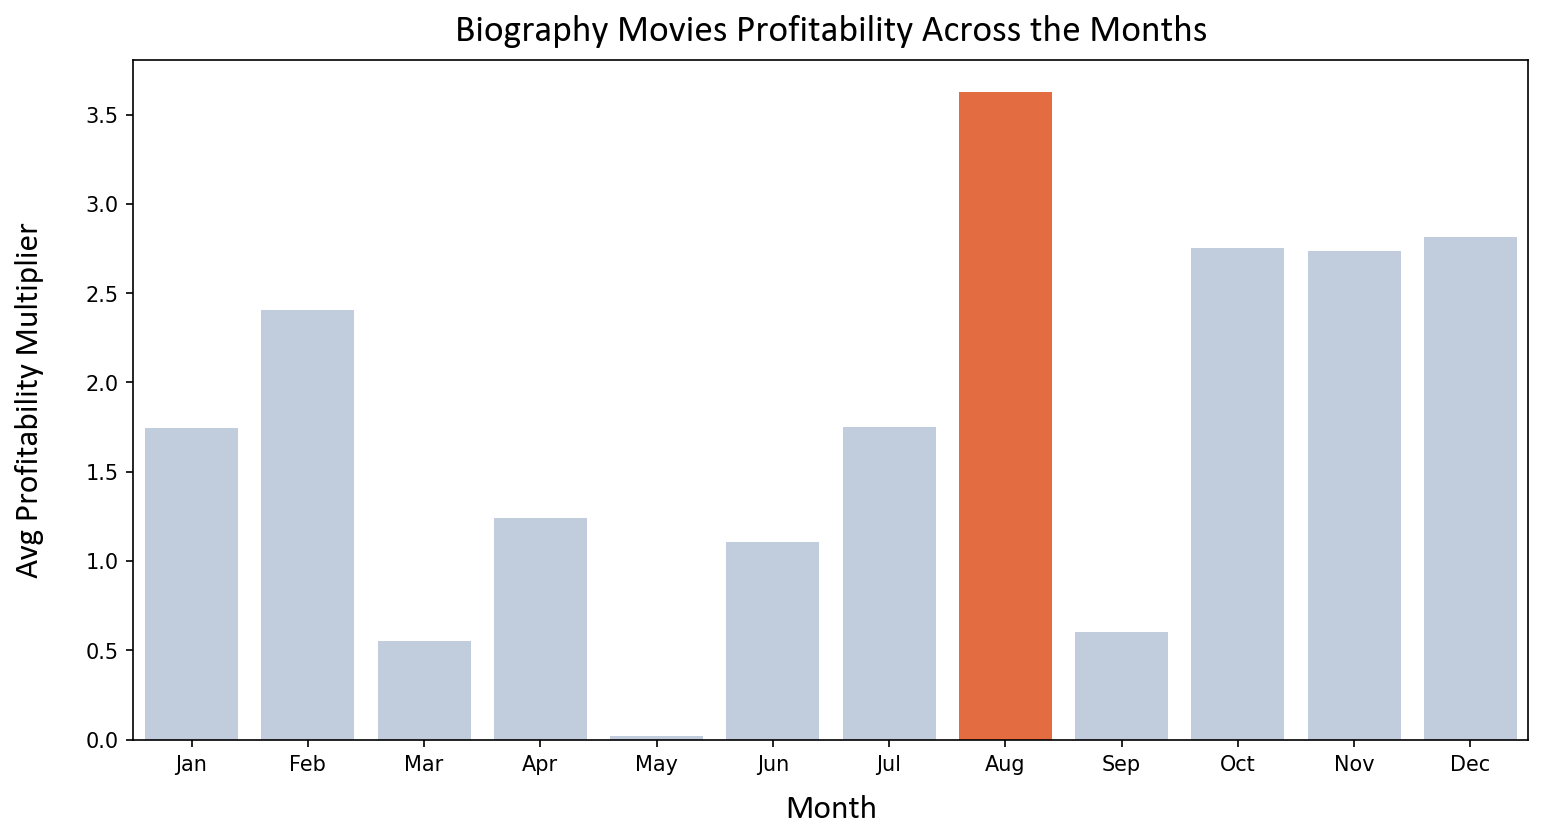

In [151]:
top_profit_m = top_profit[top_profit['genres'] == 'History']

fig, ax = plt.subplots(figsize = (12, 6), dpi = 150)
cols = ['lightsteelblue' if x < top_profit_m['profitability'].max() else 'orangered' for x in top_profit_m['profitability']]
sns.barplot(x = top_profit_m['month'], y = top_profit_m['profitability'], palette = cols, alpha = 0.85, ax = ax)
ax.set_title('History Movies Profitability Across the Months', title_font)
ax.set_xlabel('Month', label_font, labelpad = 10)
ax.set_ylabel('Avg Profitability Multiplier', label_font, labelpad = 20)
ax.set_xticklabels(months_x_ticks)

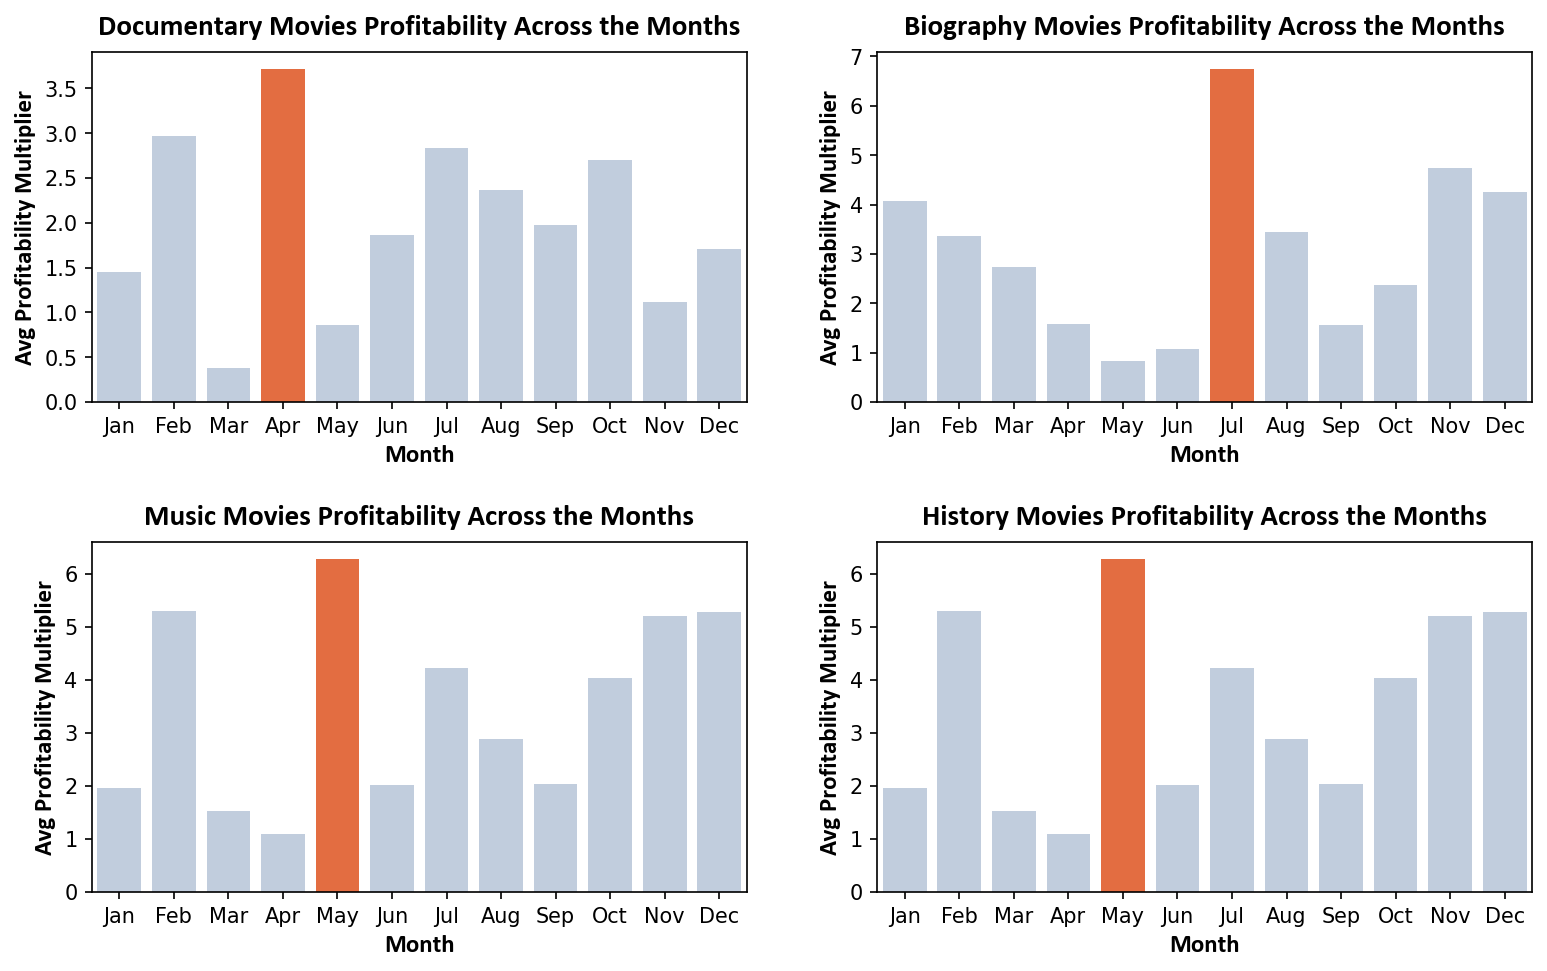

In [246]:
title_font = {'fontname':'Calibri', 'size':'14', 'color':'black', 'weight':'bold',
              'verticalalignment':'bottom'} 
label_font = {'fontname':'Calibri', 'size':'12', 'weight':'bold'}

months_x_ticks = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize = (12, 8), dpi = 150)

cols = ['lightsteelblue' if x < top_profit_d['profitability'].max() else 'orangered' for x in top_profit_d['profitability']]
sns.barplot(x = top_profit_d['month'], y = top_profit_d['profitability'], palette = cols, alpha = 0.85, ax = ax1)
ax1.set_title('Documentary Movies Profitability Across the Months', title_font)
ax1.set_xlabel('Month', label_font)
ax1.set_ylabel('Avg Profitability Multiplier', label_font)
ax1.set_xticklabels(months_x_ticks)
plt.tight_layout()

cols = ['lightsteelblue' if x < top_profit_b['profitability'].max() else 'orangered' for x in top_profit_b['profitability']]
sns.barplot(x = top_profit_b['month'], y = top_profit_b['profitability'], palette = cols, alpha = 0.85, ax = ax2)
ax2.set_title('Biography Movies Profitability Across the Months', title_font)
ax2.set_xlabel('Month', label_font)
ax2.set_ylabel('Avg Profitability Multiplier', label_font)
ax2.set_xticklabels(months_x_ticks)

cols = ['lightsteelblue' if x < top_profit_m['profitability'].max() else 'orangered' for x in top_profit_m['profitability']]
sns.barplot(x = top_profit_m['month'], y = top_profit_m['profitability'], palette = cols, alpha = 0.85, ax = ax3)
ax3.set_title('Music Movies Profitability Across the Months', title_font)
ax3.set_xlabel('Month', label_font)
ax3.set_ylabel('Avg Profitability Multiplier', label_font)
ax3.set_xticklabels(months_x_ticks)

cols = ['lightsteelblue' if x < top_profit_m['profitability'].max() else 'orangered' for x in top_profit_m['profitability']]
sns.barplot(x = top_profit_m['month'], y = top_profit_m['profitability'], palette = cols, alpha = 0.85, ax = ax4)
ax4.set_title('History Movies Profitability Across the Months', title_font)
ax4.set_xlabel('Month', label_font)
ax4.set_ylabel('Avg Profitability Multiplier', label_font)
ax4.set_xticklabels(months_x_ticks)

plt.subplots_adjust(left=0,
                    bottom=0.1,
                    right=0.8,
                    top=0.8,
                    wspace=0.2,
                    hspace=0.4)
plt.show()

# Hypothesis Testing

Null: there is no significant impact of movie genres on the profitability of movies

Alternative: There is a significant impact of movie genres on the profitability of movies

this is what I did earlier for profitability, basically 2-sample t-test between genres to see if there's a significant difference on profitability. We'd have to repeat this for however many genres we choose.

In [63]:
# Two sample t-test

genre_1 = "Documentary"
genre_2 = "Comedy"

profitability_genre_1 = merged_df[merged_df["genres"] == genre_1]["profitability"]
profitability_genre_2 = merged_df[merged_df["genres"] == genre_2]["profitability"]

t_stat, p_value = stats.ttest_ind(profitability_genre_1, profitability_genre_2)


In [64]:
x_bar_diff = profitability_genre_1.mean() - profitability_genre_2.mean()

confidence_level = 0.95

dof = len(profitability_genre_1) + len(profitability_genre_2) - 2

critical_t = stats.t.ppf(confidence_level, df=dof)

margin_of_error = critical_t * np.sqrt(
    (profitability_genre_1.var() / len(profitability_genre_1)) +
    (profitability_genre_2.var() / len(profitability_genre_2))
)

confidence_interval = (
    x_bar_diff - margin_of_error,
    x_bar_diff + margin_of_error
)

ZeroDivisionError: float division by zero

In [ ]:
print("T-Statistic:", t_stat)
print("P-Value:", p_value)
print("Mean Difference:", x_bar_diff)
print("Confidence Interval:", confidence_interval)

if p_value < alpha:
    print("Reject the null hypothesis: There is a significant impact of genres on profitability.")
else:
    print("Fail to reject the null hypothesis: There is no significant impact of genres on profitability.")

# Rotten Tomatoes

In [ ]:
"""
Rotten tomatoes have a lot of nulls (info), useful variables could be review & ratings (24% nulls)
"""
proportion_na(rt_r_df)

In [ ]:
proportion_na(rt_info_df)

# Univariate Analysis

# Multivariate Analysis